# Limb

In [1]:
# need this for jupyter notebook to import from the parent directory
import os, sys
sys.path.append('../')
# import SequenceReader() class
from utils.seq_reader import *
import matplotlib.pyplot as plt
%matplotlib inline

#### 1) Create an instance of SequenceReader() with target expression and the k-mer length

In [2]:
seq_reader = SequenceReader('limb', 6)

#### 2) Read the entire file

In [3]:
seq_reader.read_all()

106363it [00:15, 7082.84it/s]

Total lines read: 106363
Total sequences read: 2892
Number of seqs with enhancer activity: 1574
# of Positive sequence with limb expression : 337
# of Negative sequence with limb expression : 2555


#### 3) Get keys and entire features

In [4]:
keys, entire_features = seq_reader.get_entire_features()

#### 4) Import all the necessary Scikit packages

In [5]:
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve
from sklearn import svm
from sklearn.model_selection import ShuffleSplit, GridSearchCV, KFold, cross_val_score

#### 5) Set negative dataset for training
From the paper:
 To test the scaling with negative set size, we used three negative sets (roughly balanced, 1x, 5x larger, and 100x larger than the positive enhancer set). (...)
 
To replicate this, we first train our model based on roughly balanced dataset. We shuffle the negative dataset, shuffle it, and take the first (POSITIVE_CNT times NEGATIVE_SCALE) entries as a new negatives for training.

In [6]:
NEGATIVE_SCALE = 1
POSITIVE_CNT = len(entire_features['True'])

# 1) Fetch all negatives
negatives = entire_features['False']

# 2) Take the negative elements of the now randomized array based on "NEGATIVE_SCALE"
negatives = negatives[:POSITIVE_CNT*NEGATIVE_SCALE]

print "Negative Scale: {}".format(NEGATIVE_SCALE)
print "Positive counts: {}, Negative counts for training: {}".format(POSITIVE_CNT, len(negatives))

Negative Scale: 1
Positive counts: 337, Negative counts for training: 337


#### 6) Convert the entire features into X and y dataset for training

In [7]:
X = [entry[0] for entry in (entire_features['True'] + negatives)]
X = np.array(X)

In [8]:
y = [1 for _ in entire_features['True']] + [0 for _ in negatives]
y = np.array(y)

#### 7) Shuffle and split into train/val and test dataset

In [9]:
rs = ShuffleSplit(n_splits=1,
                  random_state=7,
                  test_size=0.2,
                  train_size=None)
print "Shuffle/Split Complete!"

Shuffle/Split Complete!


#### 8) Setup for Cross-validation & Grid search of model and its hyperparameters

In [10]:
tuned_parameters = [{'C': [0.1, 1, 10, 1000], 'gamma': [1e-3, 1e-4, 1e-5], 'kernel': ['rbf']}]
scores = ['roc_auc']
target_names = ['Negative', 'Positive']
STATS_DIR = '../stats/limb'
if not os.path.exists(STATS_DIR):
    os.makedirs(STATS_DIR)

#### 9) Create a train/val and test dataset based on shuffle/split

In [11]:
X_train, X_test = [], []
y_train, y_test = [], []
for train_indices, test_indices in rs.split(X):
    for train_index in train_indices:
        X_train.append(X[train_index])
        y_train.append(y[train_index])
    print "Finished generating train set!"
    for test_index in test_indices:
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    print "Finished generating test set!"

Finished generating train set!
Finished generating test set!


#### 10) Verify whether train/val and test dataset has correct distribution as intended

In [12]:
def render_cnt_and_ratio(total_list):
    total = len(total_list)
    cnt_1 = np.count_nonzero(total_list)
    cnt_0 = total - cnt_1
    ratio = [cnt_0*1.0/total, cnt_1*1.0/total]
    return [cnt_0, cnt_1], ratio

([<matplotlib.axis.XTick at 0x112217490>,
 <a list of 2 Text xticklabel objects>)

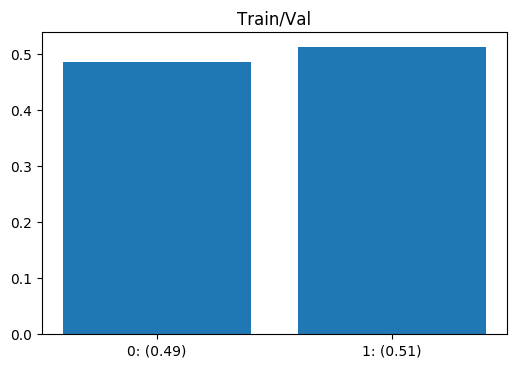

In [13]:
cnts, ratios = render_cnt_and_ratio(y_train)

fig, ax = plt.subplots()
plt.subplot(111)
plt.title('Train/Val')
plt.bar([0,1], ratios)
plt.xticks([0, 1], ('0: ({0:.2f})'.format(ratios[0]),'1: ({0:.2f})'.format(ratios[1])))

([<matplotlib.axis.XTick at 0x112384550>,
 <a list of 2 Text xticklabel objects>)

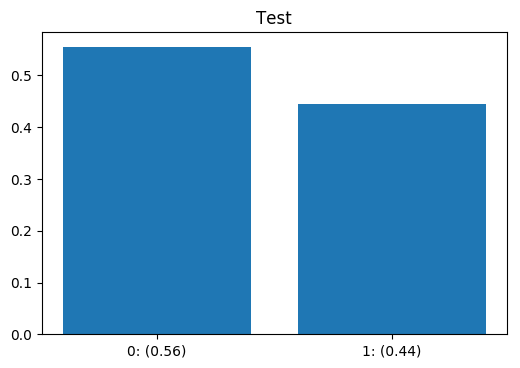

In [14]:
cnts, ratios = render_cnt_and_ratio(y_test)

fig, ax = plt.subplots()
plt.subplot(111)
plt.title('Test')
plt.bar([0,1], ratios)
plt.xticks([0, 1], ('0: ({0:.2f})'.format(ratios[0]),'1: ({0:.2f})'.format(ratios[1])))

#### 11) Run Grid Search based on 5-fold cross validation

In [15]:
for score in scores:
    print "# Tuning hyper-parameters for %s" % score
    
    scoring = '%s_macro' % score if score is not 'roc_auc' else score

    clf = GridSearchCV(svm.SVC(probability=True),
                       tuned_parameters,
                       cv=5,
                       scoring=scoring)
    clf.fit(X_train, y_train)

    print "Best parameters set found on development set:"
    print clf.best_params_
    
    print "Grid scores on development set:"
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print "%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params)

    print "Detailed classification report:" 
 
    print "The model is trained on the full development set."
    print "The scores are computed on the full evaluation set."

    # classification report and auroc on test
    print "Performance on Test Set"
    y_true, y_pred = y_test, clf.predict(X_test)
    print classification_report(y_true, y_pred, target_names=target_names)
    
    probas_ = clf.predict_proba(X_test)
    fpr_1, tpr_1, thresholds = roc_curve(y_test, probas_[:, 1])
    
    np.save(os.path.join(STATS_DIR, "svm_rbf_1_fpr_test.npy"), fpr_1)
    np.save(os.path.join(STATS_DIR, "svm_rbf_1_tpr_test.npy"), tpr_1)
    
    precision_1, recall_1, thresholds = precision_recall_curve(y_test, probas_[:, 1])
    
    np.save(os.path.join(STATS_DIR, "svm_rbf_1_precision_test.npy"), precision_1)
    np.save(os.path.join(STATS_DIR, "svm_rbf_1_recall_test.npy")   , recall_1)

# Tuning hyper-parameters for roc_auc
Best parameters set found on development set:
{'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
Grid scores on development set:
0.784 (+/-0.094) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.001}
0.784 (+/-0.093) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.0001}
0.783 (+/-0.094) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 1e-05}
0.783 (+/-0.093) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.784 (+/-0.093) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.784 (+/-0.094) for {'kernel': 'rbf', 'C': 1, 'gamma': 1e-05}
0.783 (+/-0.093) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.783 (+/-0.093) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.784 (+/-0.094) for {'kernel': 'rbf', 'C': 10, 'gamma': 1e-05}
0.867 (+/-0.054) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
0.820 (+/-0.081) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}
0.783 (+/-0.093) for {'kernel': 'rbf', 'C': 1000, 'gamma': 1e-05}
Detailed classification report:
The model is trained on the f

#### 12) Repeat this whole process for NEGATIVE_SCALE = 2

In [16]:
import random
NEGATIVE_SCALE = 2
POSITIVE_CNT = len(entire_features['True'])

# 1) Fetch all negatives
negatives = entire_features['False']

# 2) Take the negative elements of the now randomized array based on "NEGATIVE_SCALE"
negatives = negatives[:POSITIVE_CNT*NEGATIVE_SCALE]

print "Negative Scale: {}".format(NEGATIVE_SCALE)
print "Positive counts: {}, Negative counts for training: {}".format(POSITIVE_CNT, len(negatives))

X = [entry[0] for entry in (entire_features['True'] + negatives)]
X = np.array(X)

y = [1 for _ in entire_features['True']] + [0 for _ in negatives]
y = np.array(y)

tuned_parameters = [{'C': [0.1, 1, 10, 1000], 'gamma': [1e-3, 1e-4, 1e-5], 'kernel': ['rbf']}]
scores = ['roc_auc']
target_names = ['Negative', 'Positive']
STATS_DIR = '../stats/limb'
if not os.path.exists(STATS_DIR):
    os.makedirs(STATS_DIR)

X_train, X_test = [], []
y_train, y_test = [], []
for train_indices, test_indices in rs.split(X):
    for train_index in train_indices:
        X_train.append(X[train_index])
        y_train.append(y[train_index])
    print "Finished generating train set!"
    for test_index in test_indices:
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    print "Finished generating test set!"

def render_cnt_and_ratio(total_list):
    total = len(total_list)
    cnt_1 = np.count_nonzero(total_list)
    cnt_0 = total - cnt_1
    ratio = [cnt_0*1.0/total, cnt_1*1.0/total]
    return [cnt_0, cnt_1], ratio

Negative Scale: 2
Positive counts: 337, Negative counts for training: 674
Finished generating train set!
Finished generating test set!


([<matplotlib.axis.XTick at 0x11542ffd0>,
 <a list of 2 Text xticklabel objects>)

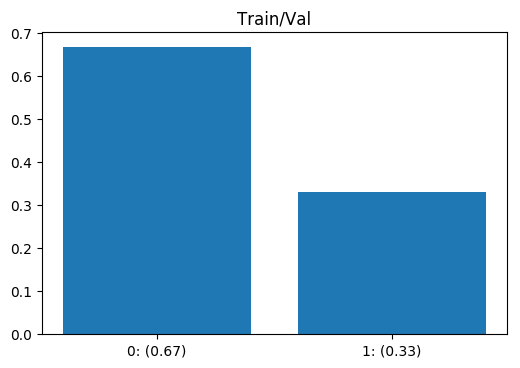

In [17]:
cnts, ratios = render_cnt_and_ratio(y_train)

fig, ax = plt.subplots()
plt.subplot(111)
plt.title('Train/Val')
plt.bar([0,1], ratios)
plt.xticks([0, 1], ('0: ({0:.2f})'.format(ratios[0]),'1: ({0:.2f})'.format(ratios[1])))

([<matplotlib.axis.XTick at 0x11561d610>,
 <a list of 2 Text xticklabel objects>)

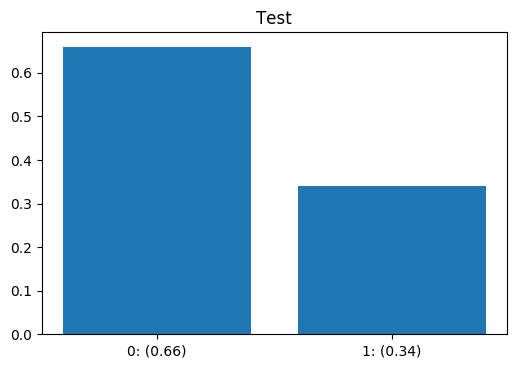

In [18]:
cnts, ratios = render_cnt_and_ratio(y_test)

fig, ax = plt.subplots()
plt.subplot(111)
plt.title('Test')
plt.bar([0,1], ratios)
plt.xticks([0, 1], ('0: ({0:.2f})'.format(ratios[0]),'1: ({0:.2f})'.format(ratios[1])))

In [19]:
for score in scores:
    print "# Tuning hyper-parameters for %s" % score
    
    scoring = '%s_macro' % score if score is not 'roc_auc' else score

    clf = GridSearchCV(svm.SVC(probability=True),
                       tuned_parameters,
                       cv=5,
                       scoring=scoring)
    clf.fit(X_train, y_train)

    print "Best parameters set found on development set:"
    print clf.best_params_
    
    print "Grid scores on development set:"
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print "%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params)

    print "Detailed classification report:" 
 
    print "The model is trained on the full development set."
    print "The scores are computed on the full evaluation set."

    # classification report and auroc on test
    print "Performance on Test Set"
    y_true, y_pred = y_test, clf.predict(X_test)
    print classification_report(y_true, y_pred, target_names=target_names)
    
    probas_ = clf.predict_proba(X_test)
    fpr_2, tpr_2, thresholds = roc_curve(y_test, probas_[:, 1])
    
    np.save(os.path.join(STATS_DIR, "svm_rbf_2_fpr_test.npy"), fpr_2)
    np.save(os.path.join(STATS_DIR, "svm_rbf_2_tpr_test.npy"), tpr_2)
    
    precision_2, recall_2, thresholds = precision_recall_curve(y_test, probas_[:, 1])
    
    np.save(os.path.join(STATS_DIR, "svm_rbf_2_precision_test.npy"), precision_2)
    np.save(os.path.join(STATS_DIR, "svm_rbf_2_recall_test.npy")   , recall_2)

# Tuning hyper-parameters for roc_auc
Best parameters set found on development set:
{'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
Grid scores on development set:
0.836 (+/-0.036) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.001}
0.837 (+/-0.037) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.0001}
0.837 (+/-0.039) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 1e-05}
0.843 (+/-0.040) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.837 (+/-0.037) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.838 (+/-0.037) for {'kernel': 'rbf', 'C': 1, 'gamma': 1e-05}
0.843 (+/-0.040) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.843 (+/-0.040) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.838 (+/-0.037) for {'kernel': 'rbf', 'C': 10, 'gamma': 1e-05}
0.879 (+/-0.037) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
0.852 (+/-0.040) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}
0.843 (+/-0.040) for {'kernel': 'rbf', 'C': 1000, 'gamma': 1e-05}
Detailed classification report:
The model is trained on the f

#### 13) Repeat this whole process for NO NEGATIVE_SCALE (use all negatives as is)

In [20]:
# No negative scale - use full negatives

# 1) Fetch all negatives
negatives = entire_features['False']

X = [entry[0] for entry in (entire_features['True'] + negatives)]
X = np.array(X)

y = [1 for _ in entire_features['True']] + [0 for _ in negatives]
y = np.array(y)

tuned_parameters = [{'C': [0.1, 1, 10, 1000], 'gamma': [1e-3, 1e-4, 1e-5], 'kernel': ['rbf']}]
scores = ['roc_auc']
target_names = ['Negative', 'Positive']
STATS_DIR = '../stats/limb'
if not os.path.exists(STATS_DIR):
    os.makedirs(STATS_DIR)

X_train, X_test = [], []
y_train, y_test = [], []
for train_indices, test_indices in rs.split(X):
    for train_index in train_indices:
        X_train.append(X[train_index])
        y_train.append(y[train_index])
    print "Finished generating train set!"
    for test_index in test_indices:
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    print "Finished generating test set!"

def render_cnt_and_ratio(total_list):
    total = len(total_list)
    cnt_1 = np.count_nonzero(total_list)
    cnt_0 = total - cnt_1
    ratio = [cnt_0*1.0/total, cnt_1*1.0/total]
    return [cnt_0, cnt_1], ratio

Finished generating train set!
Finished generating test set!


([<matplotlib.axis.XTick at 0x112302bd0>,
 <a list of 2 Text xticklabel objects>)

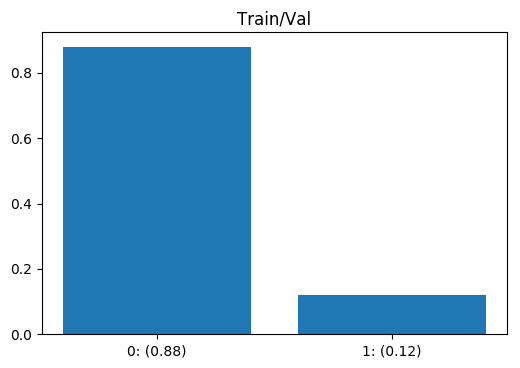

In [21]:
cnts, ratios = render_cnt_and_ratio(y_train)

fig, ax = plt.subplots()
plt.subplot(111)
plt.title('Train/Val')
plt.bar([0,1], ratios)
plt.xticks([0, 1], ('0: ({0:.2f})'.format(ratios[0]),'1: ({0:.2f})'.format(ratios[1])))

([<matplotlib.axis.XTick at 0x11655ad90>,
 <a list of 2 Text xticklabel objects>)

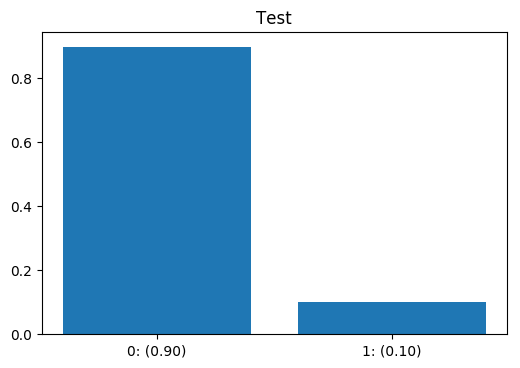

In [22]:
cnts, ratios = render_cnt_and_ratio(y_test)

fig, ax = plt.subplots()
plt.subplot(111)
plt.title('Test')
plt.bar([0,1], ratios)
plt.xticks([0, 1], ('0: ({0:.2f})'.format(ratios[0]),'1: ({0:.2f})'.format(ratios[1])))

In [23]:
for score in scores:
    print "# Tuning hyper-parameters for %s" % score
    
    scoring = '%s_macro' % score if score is not 'roc_auc' else score

    clf = GridSearchCV(svm.SVC(probability=True),
                       tuned_parameters,
                       cv=5,
                       scoring=scoring)
    clf.fit(X_train, y_train)

    print "Best parameters set found on development set:"
    print clf.best_params_
    
    print "Grid scores on development set:"
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print "%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params)

    print "Detailed classification report:" 
 
    print "The model is trained on the full development set."
    print "The scores are computed on the full evaluation set."

    # classification report and auroc on test
    print "Performance on Test Set"
    y_true, y_pred = y_test, clf.predict(X_test)
    print classification_report(y_true, y_pred, target_names=target_names)
    
    probas_ = clf.predict_proba(X_test)
    fpr_all, tpr_all, thresholds = roc_curve(y_test, probas_[:, 1])
    
    np.save(os.path.join(STATS_DIR, "svm_rbf_all_fpr_test.npy"), fpr_all)
    np.save(os.path.join(STATS_DIR, "svm_rbf_all_tpr_test.npy"), tpr_all)
    
    precision_all, recall_all, thresholds = precision_recall_curve(y_test, probas_[:, 1])
    
    np.save(os.path.join(STATS_DIR, "svm_rbf_all_precision_test.npy"), precision_all)
    np.save(os.path.join(STATS_DIR, "svm_rbf_all_recall_test.npy")   , recall_all)

# Tuning hyper-parameters for roc_auc
Best parameters set found on development set:
{'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}
Grid scores on development set:
0.562 (+/-0.037) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.001}
0.563 (+/-0.048) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.0001}
0.582 (+/-0.037) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 1e-05}
0.589 (+/-0.040) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.564 (+/-0.045) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.571 (+/-0.059) for {'kernel': 'rbf', 'C': 1, 'gamma': 1e-05}
0.611 (+/-0.030) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.590 (+/-0.022) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.571 (+/-0.059) for {'kernel': 'rbf', 'C': 10, 'gamma': 1e-05}
0.611 (+/-0.028) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
0.611 (+/-0.029) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}
0.609 (+/-0.030) for {'kernel': 'rbf', 'C': 1000, 'gamma': 1e-05}
Detailed classification report:
The model is trained on the 

/Users/jesikmin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 14) Plot auROC curves

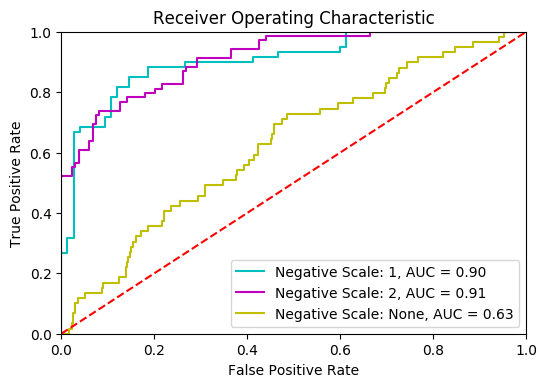

In [32]:
roc_auc_1 = auc(fpr_1, tpr_1)
roc_auc_2 = auc(fpr_2, tpr_2)
roc_auc_all = auc(fpr_all, tpr_all)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_1, tpr_1, 'c', label = 'Negative Scale: %d, AUC = %0.2f' % (1, roc_auc_1))
plt.plot(fpr_2, tpr_2, 'm', label = 'Negative Scale: %d, AUC = %0.2f' % (2, roc_auc_2))
plt.plot(fpr_all, tpr_all, 'y', label = 'Negative Scale: %s, AUC = %0.2f' % ('None', roc_auc_all))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### 15) Plot auPRC curves

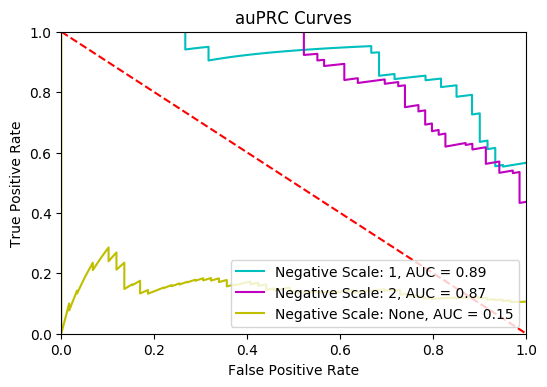

In [39]:
prc_auc_1 = auc(recall_1, precision_1)
prc_auc_2 = auc(recall_2, precision_2)
prc_auc_all = auc(recall_all, precision_all)
plt.title('auPRC Curves')
plt.plot(recall_1, precision_1, 'c', label = 'Negative Scale: %d, AUC = %0.2f' % (1, prc_auc_1))
plt.plot(recall_2, precision_2, 'm', label = 'Negative Scale: %d, AUC = %0.2f' % (2, prc_auc_2))
plt.plot(recall_all, precision_all, 'y', label = 'Negative Scale: %s, AUC = %0.2f' % ('None', prc_auc_all))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 0],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()